# Daily Water Intake & Hydration Patterns Dataset

Dataset Description:

This dataset focuses on analyzing daily water intake and hydration levels of individuals based on a combination of demographic, lifestyle, and environmental factors. Each row represents a single individual and captures how variables such as age, gender, body weight, physical activity level, and weather conditions influence daily water consumption and overall hydration status.

The goal is to predict whether an individual is properly hydrated (Good) or at risk of dehydration (Poor).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
df = pd.read_csv("Daily_Water_Intake.xls")

In [ ]:
df.head()

,Age,Gender,Weight (kg),Daily Water Intake (liters),Physical Activity Level,Weather,Hydration Level
0,56,Male,96,4.23,Moderate,Hot,Good
1,60,Male,105,3.95,High,Normal,Good
2,36,Male,68,2.39,Moderate,Cold,Good
3,19,Female,74,3.13,Moderate,Hot,Good
4,38,Male,77,2.11,Low,Normal,Poor


In [ ]:
df.shape

(30000, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          30000 non-null  int64  
 1   Gender                       30000 non-null  object 
 2   Weight (kg)                  30000 non-null  int64  
 3   Daily Water Intake (liters)  30000 non-null  float64
 4   Physical Activity Level      30000 non-null  object 
 5   Weather                      30000 non-null  object 
 6   Hydration Level              30000 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.6+ MB


In [ ]:
# Checking Null Values
df.isnull().sum()

Age                            0
Gender                         0
Weight (kg)                    0
Daily Water Intake (liters)    0
Physical Activity Level        0
Weather                        0
Hydration Level                0
dtype: int64

In [ ]:
# Checking Duplicates
df.duplicated().sum()

np.int64(338)

In [ ]:
# Remove duplicates
df = df.drop_duplicates()

In [ ]:
# Statistical Summary
df.describe()

,Age,Weight (kg),Daily Water Intake (liters)
count,29662.000000,29662.000000,29662.000000
mean,43.408199,77.065471,2.864480
std,14.990058,18.677993,0.829543
min,18.000000,45.000000,1.500000
25%,30.000000,61.000000,2.230000
50%,43.000000,77.000000,2.840000
75%,56.000000,93.000000,3.450000
max,69.000000,109.000000,5.430000


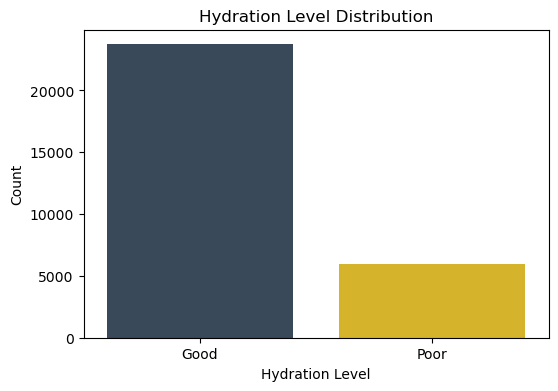

In [ ]:
# Target Variable Distribution

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Hydration Level", hue="Hydration Level",  palette=["#34495e", "#f1c40f"], legend=False)
plt.title("Hydration Level Distribution")
plt.xlabel("Hydration Level")
plt.ylabel("Count")
plt.show()

INTERPRETATIONS:

- The bar for Good hydration is much higher than the Poor bar.
- The dataset is skewed heavily toward Good hydration, with significantly fewer Poor cases.

In [ ]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("\nNumeric Columns:", list(numeric_cols))
print("\nCategorical Columns:", list(categorical_cols))



Numeric Columns: ['Age', 'Weight (kg)', 'Daily Water Intake (liters)']

Categorical Columns: ['Gender', 'Physical Activity Level', 'Weather', 'Hydration Level']


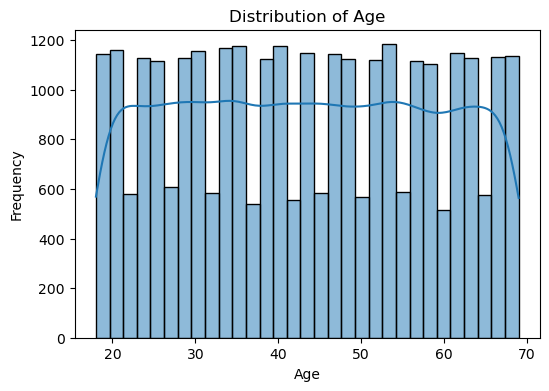

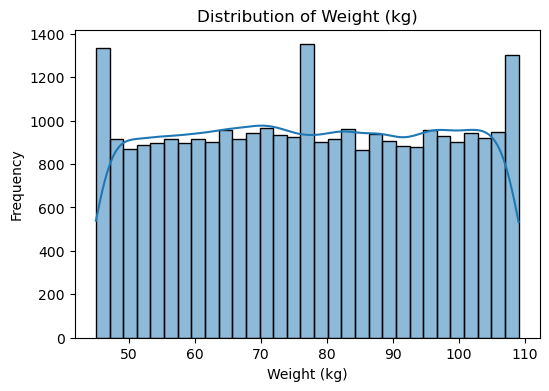

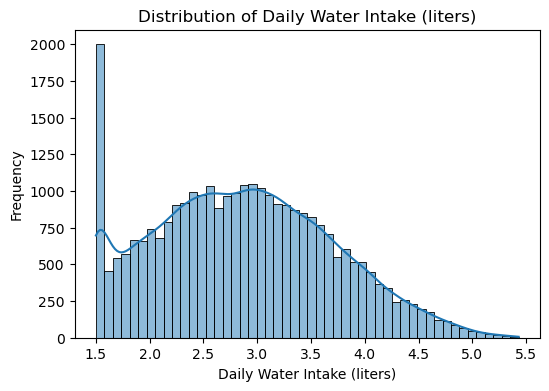

In [ ]:
# Distribution of Numeric Columns
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

INTERPRETATIONS:

1. Distribution of Age
- The dataset contains a fairly even mix of individuals aged 18–70, with a slightly higher presence of people aged 25–50.

2. Weight Distribution
- The dataset shows a broad and fairly uniform spread of body weights from 45 kg to 110 kg, with a slight concentration in the 65–90 kg range but no dominant weight group.

3. Daily Water Intake
- Most individuals consume between 2–3.5 liters of water per day, with intake gradually decreasing at higher levels. The pattern suggests a healthy central tendency with fewer people consuming either very low or very high amounts of water.

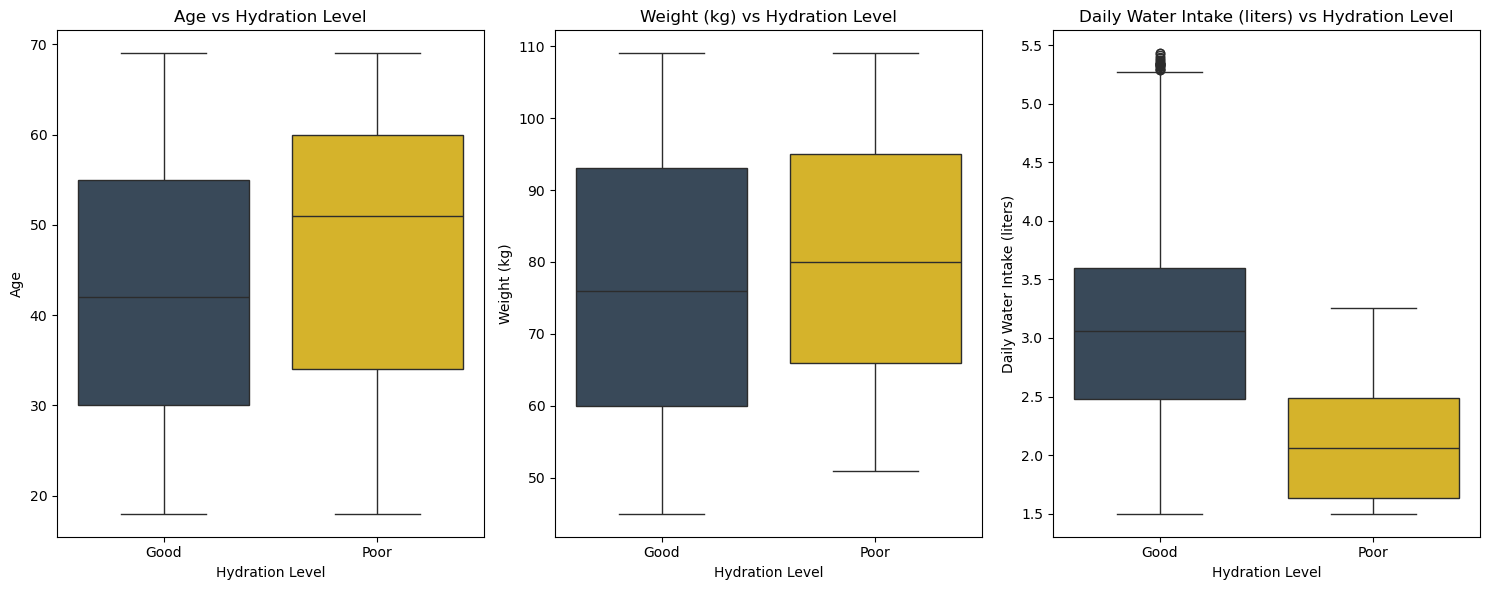

In [ ]:
# Numeric features vs Target
plt.figure(figsize=(15, 6))

palette_list = ["#34495e", "#f1c40f"]

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x="Hydration Level", y=col, hue="Hydration Level", palette=palette_list)
    plt.title(f"{col} vs Hydration Level")
    plt.xlabel("Hydration Level")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

INTERPRETATIONS:

1. Age vs Hydration Level
- Individuals with Poor Hydration tend to be slightly older on average.
- Both groups include a wide age range, indicating people of all ages can experience both good and poor hydration.

2. Weight (kg) vs Hydration Level
- The spread of weights is fairly similar across both categories.
- Heavier individuals may be slightly more prone to poor hydration.

3. Daily Water Intake (liters) vs Hydration Level
This feature shows the strongest and clearest difference:
- Good Hydration group has a significantly higher median water intake.
- Poor Hydration group shows consistently lower intake.
- There are some outliers with very high intake in the Good group.

<Figure size 800x500 with 0 Axes>

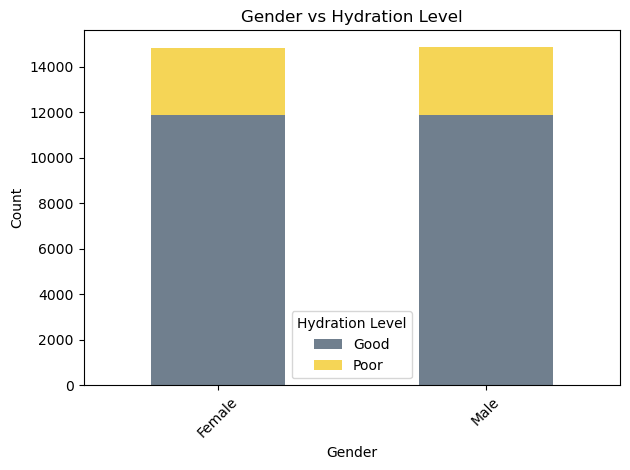

<Figure size 800x500 with 0 Axes>

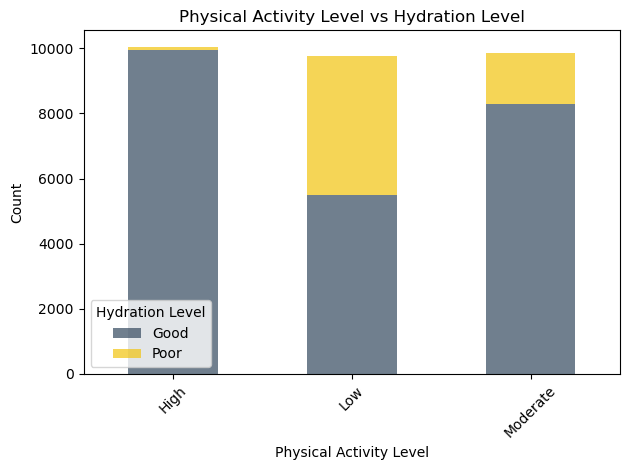

<Figure size 800x500 with 0 Axes>

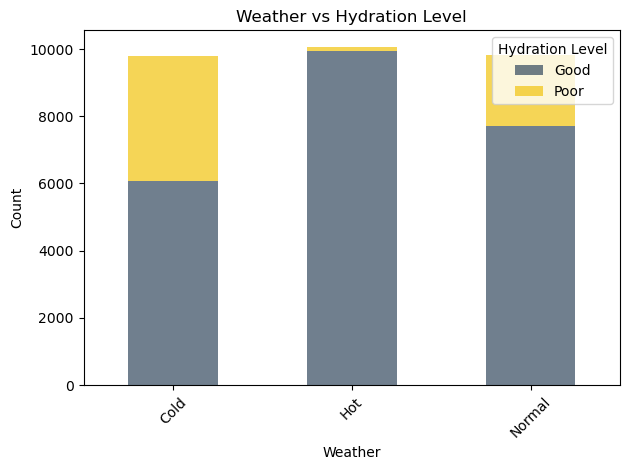

In [ ]:
# Categorical Features vs Target
for col in categorical_cols:
    if col == 'Hydration Level':
        continue

    plt.figure(figsize=(8,5))

    counts = pd.crosstab(df[col], df['Hydration Level'])
    counts.plot(kind='bar', stacked=True, alpha=0.7, color=["#34495e", "#f1c40f"])

    plt.title(f"{col} vs Hydration Level")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Hydration Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

INTERPRETATIONS:

1. Gender vs Hydration Level
- Hydration behavior appears fairly consistent across males and females.

2. Physical Activity Level vs Hydration Level
- Individuals with High Physical Activity show the highest number of Good Hydration cases.
- Moderate Activity also has mostly Good Hydration, but slightly more Poor cases than high activity.
- Low Activity group shows the highest proportion of Poor Hydration relative to its size.

3. Weather vs Hydration Level
- In Hot weather, most people maintain Good Hydration (likely because they drink more water).
- In Normal weather, there is a moderate number of Poor Hydration cases.
- In Cold weather, Poor Hydration rises significantly, and Good Hydration decreases.

C:\Users\sheetal\AppData\Local\Temp\ipykernel_26752\3905146407.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(numerical_columns.values, labels=numerical_columns.columns)


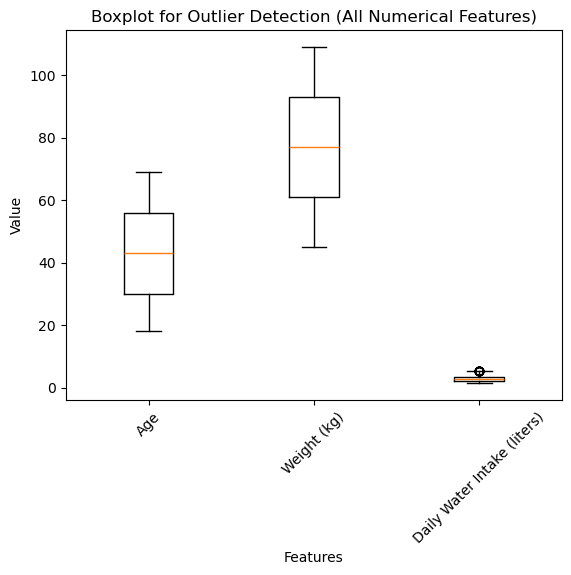

In [ ]:
# Boxplot

numerical_columns = df.select_dtypes(include=['int64', 'float64'])

plt.figure()
plt.boxplot(numerical_columns.values, labels=numerical_columns.columns)
plt.title("Boxplot for Outlier Detection (All Numerical Features)")
plt.xlabel("Features")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

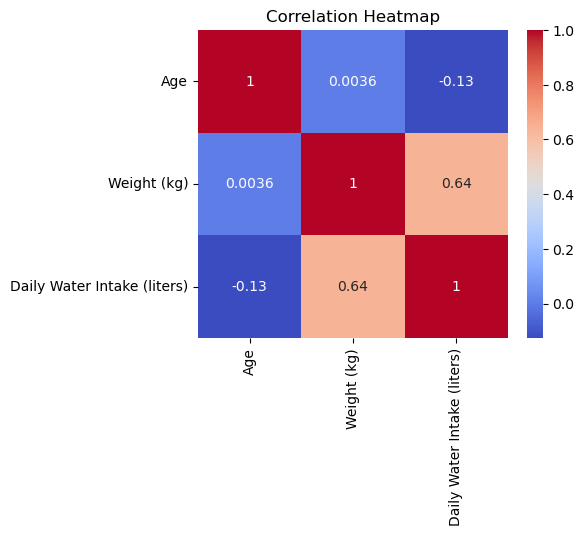

In [ ]:
# Correlation Heatmap

corr = df.corr(numeric_only=True)
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

INTERPRETATION:

- Most variables have weak correlations
- Weight (kg) , Daily Water Intake (liters)-> 0.64 are the most meaningful relationship

In [ ]:
# Feature Selection
X = df.drop('Hydration Level', axis=1)
y = df['Hydration Level']

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Good': np.int64(0), 'Poor': np.int64(1)}


In [ ]:
# Preprocessing
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)])

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

In [ ]:
y.value_counts()

Hydration Level
Good    23730
Poor     5932
Name: count, dtype: int64

In [ ]:
# Define Models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),

    "SVM": SVC(probability=True),

    "KNN": KNeighborsClassifier(),

    "Decision Tree": DecisionTreeClassifier(random_state=42),

    "Random Forest": RandomForestClassifier(random_state=42),

    "Gradient Boosting": GradientBoostingClassifier(random_state=42),

    "AdaBoost": AdaBoostClassifier(random_state=42),

    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42
    )
}

In [ ]:
# Update Parameter Grids

param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
         "model__solver": ["lbfgs"],
         "model__class_weight": [None, "balanced"]
    },

    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__kernel": ["linear", "rbf"],
        "model__gamma": ["scale", "auto"]
    },

    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"]
    },

    "Decision Tree": {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5],
        "model__class_weight": [None, "balanced"]
    },

    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 10, 20],
        "model__class_weight": [None, "balanced"]
    },

    "Gradient Boosting": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [3, 5]
    },

    "AdaBoost": {
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.5, 1.0]
    },

    "XGBoost": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
         "model__max_depth": [3, 5],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.8, 1.0]
    }
}

In [ ]:
results = []
best_f1 = 0
best_model = None
best_model_name = None

for name, model in models.items():
    print(f"\n========== {name} ==========")

    # Pipeline with preprocessing, SMOTE (for training), and model
    pipeline = Pipeline([
        ("preprocess", preprocessor),   # handles scaling + encoding
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring="f1_weighted",
        n_jobs=-1
    )

    # Fit on training data
    grid.fit(X_train, y_train)

    best_pipeline = grid.best_estimator_

    # Predict on train and test
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred  = best_pipeline.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    test_f1   = f1_score(y_test, y_test_pred, average="weighted", zero_division=0)

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "F1": test_f1,
        "CV F1": grid.best_score_
    })

    print("Best Params:", grid.best_params_)
    print(classification_report(y_test, y_test_pred))

    # Update best model
    if grid.best_score_ > best_f1:
        best_f1 = grid.best_score_
        best_model = best_pipeline
        best_model_name = name

print(f"\nBest Model: {best_model_name} with CV F1: {best_f1:.4f}")


========== Logistic Regression ==========
Best Params: {'model__C': 10, 'model__class_weight': None, 'model__solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5933
           1       0.99      1.00      0.99      1483

    accuracy                           1.00      7416
   macro avg       0.99      1.00      1.00      7416
weighted avg       1.00      1.00      1.00      7416


========== SVM ==========
Best Params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5933
           1       1.00      1.00      1.00      1483

    accuracy                           1.00      7416
   macro avg       1.00      1.00      1.00      7416
weighted avg       1.00      1.00      1.00      7416


========== KNN ==========
Best Params: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'model__weigh

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV F1", ascending=False)

print("\n======= Summary =======")
print(results_df)


======= Summary =======
                 Model  Train Accuracy  Test Accuracy        F1     CV F1
1                  SVM        0.998651       0.998652  0.998652  0.998429
7              XGBoost        0.999775       0.996224  0.996231  0.996859
0  Logistic Regression        0.997078       0.997303  0.997310  0.995971
5    Gradient Boosting        1.000000       0.997438  0.997441  0.995828
3        Decision Tree        1.000000       0.991370  0.991394  0.989231
4        Random Forest        1.000000       0.984358  0.984405  0.981396
6             AdaBoost        0.974827       0.974245  0.974786  0.974035
2                  KNN        1.000000       0.967907  0.968353  0.966865


In [ ]:
def predict_new_sample(model_pipeline, new_data: pd.DataFrame):
    # Ensure same column order
    new_data = new_data[X.columns]

    # call pipeline.predict()
    prediction = model_pipeline.predict(new_data)
    return prediction

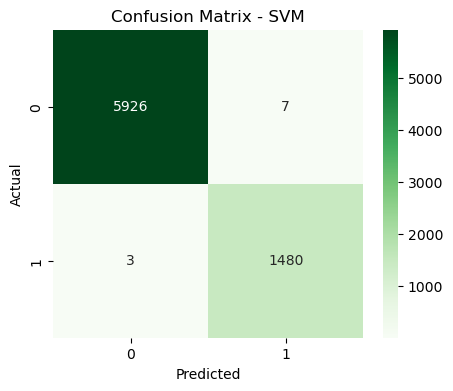

In [ ]:
# Confusion matrix for the best model
y_test_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

INTERPRETATION:

- The confusion matrix shows very high correct predictions for both classes, with minimal misclassification.
- False positives and false negatives are extremely low, indicating strong model reliability.
- No obvious bias toward class 0 or 1
- True Negatives (TN = 5926): Correctly predicted class 0
- True Positives (TP = 1480): Correctly predicted class 1
- False Positives (FP = 7): Very few class 0 misclassified as 1
- False Negatives (FN = 3): Very few class 1 missed

Total samples = 5926 + 7 + 3 + 1480 = 7416 samples

In [ ]:
# Actual vs Predicted values
df_compare = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})
print(df_compare.head(20))

    Actual  Predicted
0        0          0
1        0          0
2        0          0
3        1          1
4        0          0
5        0          0
6        0          0
7        0          0
8        0          0
9        0          0
10       0          0
11       0          0
12       0          0
13       0          0
14       0          0
15       0          0
16       0          0
17       0          0
18       1          1
19       0          0


In [ ]:
# Save the best model

joblib.dump(best_model, "best_model.joblib")
print(f"Best model ({best_model_name}) saved successfully.")

Best model (SVM) saved successfully.


In [ ]:
# Load the saved model
best_model = joblib.load('best_model.joblib')

In [ ]:
# New unseen data
new_data = pd.DataFrame({
    "Age": [25, 42],
    "Gender": ["Male", "Female"],
    "Weight (kg)": [68, 75],
    "Daily Water Intake (liters)": [2.8, 1.2],
    "Physical Activity Level": ["Moderate", "High"],
    "Weather": ["Normal","Hot"]
})

In [ ]:
# Predict Hydration Level
prediction = best_model.predict(new_data)
print("Predicted Hydration Levels:", prediction)

Predicted Hydration Levels: [0 1]


In [ ]:
label_map = {0: "Good Hydration", 1: "Poor Hydration"}

for i, pred in enumerate(prediction):
    print(f"Sample {i+1}: {label_map[pred]}")


Sample 1: Good Hydration
Sample 2: Poor Hydration


In [ ]:
new_data["Predicted Hydration"] = prediction
new_data["Hydration Label"] = new_data["Predicted Hydration"].map({
    0: "Good Hydration",
    1: "Poor Hydration"
})

print(new_data)

   Age  Gender  Weight (kg)  Daily Water Intake (liters)  \
0   25    Male           68                          2.8   
1   42  Female           75                          1.2   

  Physical Activity Level Weather  Predicted Hydration Hydration Label  
0                Moderate  Normal                    0  Good Hydration  
1                    High     Hot                    1  Poor Hydration  


Final Conclusion:

The model predicts hydration level based on age, gender, body weight, daily water intake, physical activity, and weather conditions.
Higher water intake with moderate activity results in good hydration, while low intake combined with high activity and hot weather leads to poor hydration.